In [1]:
import csv
import os
import sys
import quaternion
import argparse
import struct
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [18]:
df = pd.read_csv("01-3500-features.txt", delimiter=" ", header=None)

In [19]:

ROT_MAT = np.array([[0, 0, 1], [-1, 0, 0], [0, -1, 0]])
FPS = 30


class Pose():
    def __init__(self, time_stamp, t, q):
        self.time_stamp = time_stamp
        self.t = t
        self.q = q


In [23]:

def read_cameras_text(path):
    poses = []
    x_arr = []; y_arr = []; z_arr = []

    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                time_stamp = float(elems[0])
                t = np.array([float(elems[1]), float(elems[2]), float(elems[3])])
                t = np.dot(ROT_MAT, t)
                t[2] = 0.0
                x_arr.append(t[0])
                y_arr.append(t[1])
                z_arr.append(0.0)
                q = np.array([float(elems[4]), float(elems[5]), float(elems[6]), float(elems[7])])
                poses.append(Pose(time_stamp=time_stamp, t=t, q=q))
    return poses, x_arr, y_arr, z_arr


def find_angle(ref_q, q):
    rqvec = np.quaternion(ref_q[0], ref_q[1], ref_q[2], ref_q[3])
    qvec = np.quaternion(q[0], q[1], q[2], q[3])
    new_q = rqvec.inverse()*qvec
    ang = np.dot(np.array([0,1,0]), quaternion.as_rotation_vector(new_q))*180/np.pi
    angle = ang % 360
    return angle


def filter_poses(poses):
    pose_indices = [x for x in range(len(poses))]
    to_filter = set()
    for i in range(len(poses)):
        for j in range(len(poses)):
            dist = np.linalg.norm(poses[i].t - poses[j].t)
            if i == j or j in to_filter or i in to_filter:
                continue
            if dist < 0.5:
                to_filter.add(j)
                continue
    return [poses[i] for i in pose_indices if i not in to_filter]

def filter_poses_1(poses):
    filtered = []
    x_arr = []; y_arr = []; z_arr = []
    curr_idx = 0
    filtered.append(poses[0])
    for i in range(len(poses)):
        for idx, pose in enumerate(poses[curr_idx:]):
            dist = np.linalg.norm(pose.t - poses[curr_idx].t)
            if dist > 0.5:
                filtered.append(pose)
                curr_idx = idx
                continue
    return filtered


def save_poses(filename, poses):
    col = ['frame', 'x', 'y', 'z', 'angle']
    data = pd.DataFrame(columns=col)

    ref_pose = poses[0]
    for idx, pose in enumerate(poses):
        angle = find_angle(ref_pose.q, pose.q)
        frame = round(pose.time_stamp*FPS)
        d = {'frame': frame, 'x':pose.t[0], 'y':pose.t[1], 'z':pose.t[2], 'angle':angle}
        data.loc[idx] = pd.Series(d)
#         print("frame :" + str(frame) + "  angle: " + str(angle))
        np.save(filename, data.values)


In [24]:
filtered_poses[0].__dict__

{'time_stamp': 8.9,
 't': array([0.3410014, 0.122903 , 0.       ]),
 'q': array([0.0016726, 0.0089055, 0.003894 , 0.9999514])}

In [25]:
filename = "01.txt"
poses, x, y, z = read_cameras_text(filename)
filtered_poses = filter_poses(filter_poses_1(poses))
region = "run_1"
save_poses("data/"+ region + "/processed/pos_ang", filtered_poses)



In [7]:
len(filtered_poses)

532

In [8]:
x_f = [list(x.t)[0] for x in filtered_poses]
y_f = [list(x.t)[1] for x in filtered_poses]


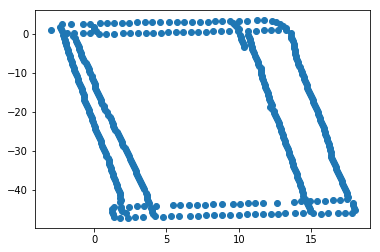

In [9]:
plt.scatter(x_f[:478], y_f[:478])

In [10]:
prefix = "/Volumes/Arnold2/panos/2019-06-10"
paths = []
for d in os.listdir(prefix):
    path = prefix + "/" + d
    for f in os.listdir(path):
        paths.append(path + "/" + f)
        

In [11]:
to_find = [str(int(x.time_stamp * 30)).zfill(6) for x in filtered_poses]

In [12]:
good_paths = []
for path in paths:
    for num in to_find:
        if num in path:
            good_paths.append(path)

In [31]:
dst_path = os.getcwd() + "/panos/"
os.mkdir(dst_path)

In [36]:
from shutil import copyfile

for path in good_paths:
    copyfile(path, dst_path + path.split("/")[-1])


In [ ]:
# points_orig = [x.t[:2] for x in poses]
# delta = []
# for idx, point1 in enumerate(points_orig):
#     if idx + 1 == len(points_orig):
#         break
#     delta.append(np.linalg.norm(points_orig[idx + 1] -point1))
# np.mean(delta) * 30

ValueError: x and y must be the same size

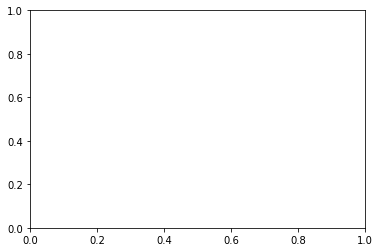

In [319]:
# last_section_x = []
# for i in range(450, 527):
#     total = 527-450
#     last_section_x.append(x_f[i] + (i-450)/total*3)
# last_section_y = y_f[450:527]
# the_bulk_x = x_f[:450]
# the_bulk_y = y_f[:450]
# plt.scatter(np.append(the_bulk_x, last_section_x), np.append(the_bulk_y, last_section_y))

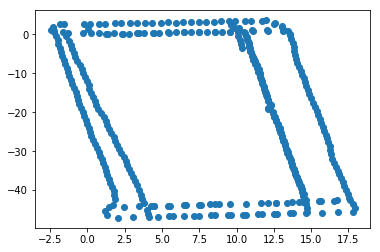

In [225]:
x = x_f[:450]
x = x[:200] + x[250:450]
y = y_f[:450]
y = y[:200] + y[250:450]

plt.scatter(x, y)

In [106]:
x_f = np.array(x_f)

In [107]:
x_f2 = x_f[10 < x_f]

In [108]:
x_f3 = x_f2[11.5 > x_f2]

In [109]:
x_f3

array([10.0936232, 11.0942926, 10.5741129, 10.5376253, 10.7085772,
       10.7829514, 10.8514862, 10.9322376, 10.98141  , 11.1249485,
       11.252387 , 11.3575144, 10.9551048, 10.1631041, 10.5332165,
       10.6410637, 10.7319098, 10.808939 , 10.865406 , 10.9348841,
       11.0352097, 11.1308422, 11.2328806, 11.3429985, 11.4634581,
       11.0283995, 10.1303043, 10.1198597, 10.2098246, 10.3123636,
       10.4002075, 10.9228849, 11.0326481, 11.1636686, 11.2600508,
       11.3450613, 11.4192829, 10.4392185, 11.468523 , 10.6642475,
       10.6202526])

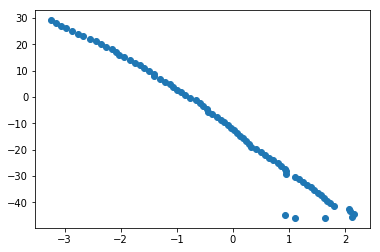

In [82]:
plt.scatter(x_f[450:527] * np.array(0.5), y_f[450:527])

In [75]:
x_f[500:527]

[-1.9878802,
 -2.1235967,
 -2.2610552,
 -2.419477,
 -2.6072614,
 -2.807421,
 -2.8295476,
 -2.9965773,
 -3.1669114,
 -3.2964277,
 -3.4979839,
 -3.6837366,
 -3.8674474,
 -4.0438123,
 -4.1821785,
 -4.3264685,
 -4.5353827,
 -4.7098641,
 -4.8892055,
 -5.0898046,
 -5.3284507,
 -5.5276246,
 -5.735754,
 -5.9304562,
 -6.1352057,
 -6.29842,
 -6.4849539]

In [71]:
len(x_f)

527